# 0. Install Dependencies and Bring in Data

In [77]:
!python --version

Python 3.9.9


In [2]:
!pip install tensorflow-macos tensorflow-metal pandas matplotlib scikit-learn

  Using cached tensorflow_macos-2.16.2-cp39-cp39-macosx_12_0_arm64.whl (2.1 kB)
  Using cached tensorflow_metal-1.1.0-cp39-cp39-macosx_12_0_arm64.whl (1.4 MB)
  Using cached pandas-2.2.3-cp39-cp39-macosx_11_0_arm64.whl (11.3 MB)
  Using cached matplotlib-3.9.4-cp39-cp39-macosx_11_0_arm64.whl (7.8 MB)
     |████████████████████████████████| 11.1 MB 9.8 MB/s eta 0:00:01
  Using cached tensorflow-2.16.2-cp39-cp39-macosx_12_0_arm64.whl (227.0 MB)
  Using cached libclang-18.1.1-1-py2.py3-none-macosx_11_0_arm64.whl (25.8 MB)
     |████████████████████████████████| 11.5 MB 6.7 MB/s eta 0:00:01
  Using cached opt_einsum-3.4.0-py3-none-any.whl (71 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached gast-0.6.0-py3-none-any.whl (21 kB)
  Using cached h5py-3.12.1-cp39-cp39-macosx_11_0_arm64.whl (2.9 MB)
  Using cached numpy-1.26.4-cp39-cp39-macosx_11_0_arm64.whl (14.0 MB)
  Using cached requests-2.32.3-py3-none-any.whl (64 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl

In [78]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [79]:
df = pd.read_csv(os.path.join('jigsaw-toxic-comment-classification-challenge','train.csv', 'train.csv'))

In [80]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# 1. Preprocess

In [6]:
!pip list

Package                      Version
---------------------------- -----------
absl-py                      2.1.0
appnope                      0.1.4
asttokens                    3.0.0
astunparse                   1.6.3
certifi                      2024.12.14
charset-normalizer           3.4.1
comm                         0.2.2
contourpy                    1.3.0
cycler                       0.12.1
debugpy                      1.8.12
decorator                    5.1.1
exceptiongroup               1.2.2
executing                    2.2.0
flatbuffers                  25.1.24
fonttools                    4.55.8
gast                         0.6.0
google-pasta                 0.2.0
grpcio                       1.70.0
h5py                         3.12.1
idna                         3.10
importlib_metadata           8.6.1
importlib_resources          6.5.2
ipykernel                    6.29.5
ipython                      8.18.1
jedi                         0.19.2
joblib                       1.4.

In [81]:
from tensorflow.keras.layers import TextVectorization

In [82]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [83]:
MAX_FEATURES = 200000 # number of words in the vocab

In [84]:
SEQUENCE_LENGTH = 1800

In [85]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=SEQUENCE_LENGTH,
                               output_mode='int')

In [86]:
vectorizer.adapt(X.values)

In [87]:
vectorized_text = vectorizer(X.values)

In [88]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [89]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

# 2. Create Sequential Model

In [90]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [94]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(input_dim=MAX_FEATURES+1, output_dim=32, input_length=SEQUENCE_LENGTH))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Dropout after LSTM layer
model.add(Dropout(0.2))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))
# Build model
model.build(input_shape=(None, SEQUENCE_LENGTH))

/Users/ankit/DeepLearning/CommentToxicity/toxicity/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [95]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [96]:
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)        │ (None, 1800, 32)       │     6,400,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 64)             │        16,640 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,491,686 (24.76 MB)

 Trainable params: 6,491,686 (24.76 MB)

 Non-trainable params: 0 (0.00 B)

In [97]:
history = model.fit(train, epochs=3, validation_data=val)

Epoch 1/3
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 1497s 214ms/step - loss: 0.1081 - val_loss: 0.1126
Epoch 2/3
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 1354s 194ms/step - loss: 44.2635 - val_loss: 340.5882
Epoch 3/3
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 1252s 179ms/step - loss: 2158.9929 - val_loss: 2266.2766


In [98]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

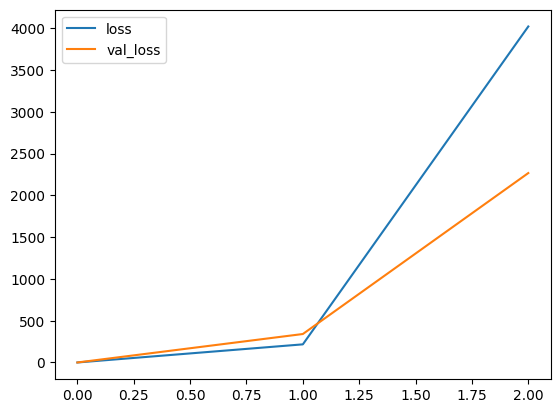

In [99]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# 3. Make Predictions

In [131]:
input_text = vectorizer('You freaking suck! I am going to hit you.')

In [132]:
res = model.predict(np.expand_dims(input_text,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


In [133]:
(res > 0.5).astype(int)

array([[1, 0, 1, 0, 0, 0]])

In [ ]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [ ]:
(model.predict(batch_X) > 0.5).astype(int)

In [ ]:
res.shape

# 4. Evaluate Model

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [ ]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

In [ ]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

# 5. Test and Gradio

In [134]:
!pip install gradio jinja2

     |████████████████████████████████| 18.1 MB 15.3 MB/s eta 0:00:01
     |████████████████████████████████| 134 kB 7.5 MB/s eta 0:00:01
  Using cached pillow-10.4.0-cp39-cp39-macosx_11_0_arm64.whl (3.4 MB)
     |████████████████████████████████| 94 kB 8.7 MB/s  eta 0:00:01
     |████████████████████████████████| 44 kB 13.4 MB/s eta 0:00:01
     |████████████████████████████████| 318 kB 9.0 MB/s eta 0:00:01
     |████████████████████████████████| 250 kB 18.8 MB/s eta 0:00:01
     |████████████████████████████████| 73 kB 8.6 MB/s  eta 0:00:01
     |████████████████████████████████| 96 kB 10.4 MB/s eta 0:00:01
  Using cached PyYAML-6.0.2-cp39-cp39-macosx_11_0_arm64.whl (172 kB)
     |████████████████████████████████| 11.1 MB 8.2 MB/s eta 0:00:01
  Using cached MarkupSafe-2.1.5-cp39-cp39-macosx_10_9_universal2.whl (18 kB)
     |████████████████████████████████| 62 kB 2.3 MB/s  eta 0:00:01
     |████████████████████████████████| 464 kB 9.6 MB/s eta 0:00:01
     |██████████████████████████

In [135]:
import tensorflow as tf
import gradio as gr

/Users/ankit/DeepLearning/CommentToxicity/toxicity/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
model.save('toxicity.h5')

In [139]:
model = tf.keras.models.load_model('toxicity.h5')

TypeError: Could not locate class 'LSTM'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'class_name': 'LSTM', 'config': {'name': 'lstm_2', 'trainable': True, 'dtype': 'float32', 'return_sequences': False, 'return_state': False, 'go_backwards': False, 'stateful': False, 'unroll': False, 'time_major': False, 'units': 32, 'activation': 'tanh', 'recurrent_activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'recurrent_initializer': {'class_name': 'Orthogonal', 'config': {'gain': 1.0, 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'unit_forget_bias': True, 'kernel_regularizer': None, 'recurrent_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'recurrent_constraint': None, 'bias_constraint': None, 'dropout': 0.0, 'recurrent_dropout': 0.0, 'implementation': 2}}

In [140]:
input_str = vectorizer('hey i freaken hate you!')

In [141]:
res = model.predict(np.expand_dims(input_str,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


In [142]:
res

array([[0., 0., 0., 0., 0., 0.]], dtype=float32)

In [143]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

In [146]:
interface = gr.Interface(fn=score_comment, 
                         inputs=gr.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

In [ ]:
interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://5996c16b13e763e85a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
